In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
entry = os.path.join('hw1-data', 'data')

train_dir = os.path.join(entry, 'train')
val_dir = os.path.join(entry, 'val')
test_dir = os.path.join(entry, 'test')

In [3]:
class_number = 100

train_sizes, val_sizes, test_sizes = [], [], []

for i in range(class_number):
    train_sizes.append(len(os.listdir(os.path.join(train_dir, str(i)))))
    val_sizes.append(len(os.listdir(os.path.join(val_dir, str(i)))))

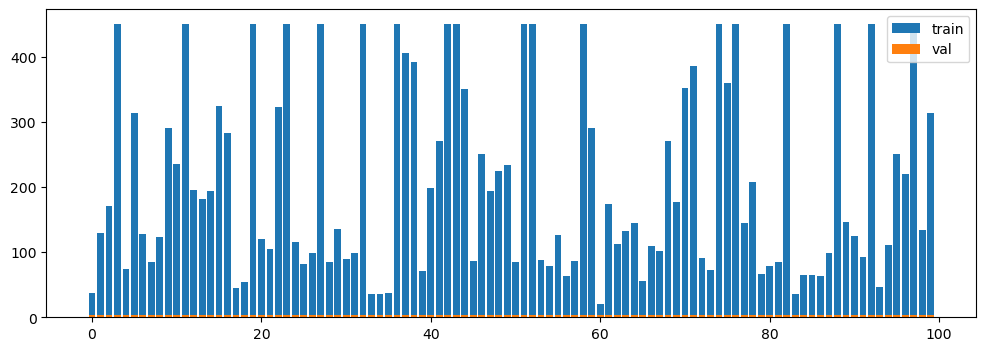

In [4]:
# check if the number of images in each class is the same
# by drawing a bar chart
plt.figure(figsize=(12, 4))
plt.bar(range(class_number), train_sizes, label='train')
plt.bar(range(class_number), val_sizes, label='val')
plt.legend()
plt.show()

In [5]:
print(min(train_sizes), max(train_sizes))
print(min(val_sizes), max(val_sizes))

20 450
3 3


In [6]:
from PIL import Image
from collections import defaultdict

train_shapes, val_shapes, test_shapes = [], [], []

all_shapes = defaultdict(int)
min_value = 10000

for dirpath, dirnames, filenames in os.walk(val_dir):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        image = Image.open(full_path).convert('RGB')
        h, w = image.size
        min_value = min(min_value, h, w)
        all_shapes[(h,w)] += 1

In [7]:
sorted_items = sorted(all_shapes.items(), key=lambda item: item[1], reverse=True)
sorted_items

[((800, 600), 82),
 ((600, 800), 72),
 ((800, 533), 27),
 ((450, 800), 16),
 ((800, 450), 12),
 ((800, 800), 11),
 ((800, 534), 5),
 ((800, 532), 4),
 ((800, 530), 3),
 ((533, 800), 3),
 ((800, 646), 2),
 ((598, 800), 2),
 ((800, 570), 2),
 ((800, 706), 2),
 ((640, 800), 1),
 ((766, 800), 1),
 ((723, 800), 1),
 ((800, 775), 1),
 ((800, 732), 1),
 ((800, 541), 1),
 ((800, 650), 1),
 ((750, 800), 1),
 ((800, 577), 1),
 ((597, 800), 1),
 ((800, 588), 1),
 ((800, 574), 1),
 ((800, 436), 1),
 ((800, 620), 1),
 ((800, 481), 1),
 ((800, 654), 1),
 ((800, 475), 1),
 ((530, 800), 1),
 ((800, 344), 1),
 ((800, 637), 1),
 ((592, 800), 1),
 ((800, 663), 1),
 ((800, 722), 1),
 ((617, 800), 1),
 ((449, 800), 1),
 ((800, 680), 1),
 ((534, 800), 1),
 ((800, 603), 1),
 ((800, 334), 1),
 ((800, 514), 1),
 ((800, 560), 1),
 ((596, 800), 1),
 ((663, 800), 1),
 ((800, 710), 1),
 ((800, 529), 1),
 ((800, 559), 1),
 ((800, 564), 1),
 ((800, 571), 1),
 ((800, 608), 1),
 ((670, 800), 1),
 ((451, 800), 1),
 ((8

/tmp/ipykernel_2395268/3099963737.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet50-mysample2/15_9020.pth"))
100%|██████████| 3

Accuracy: 95.33%


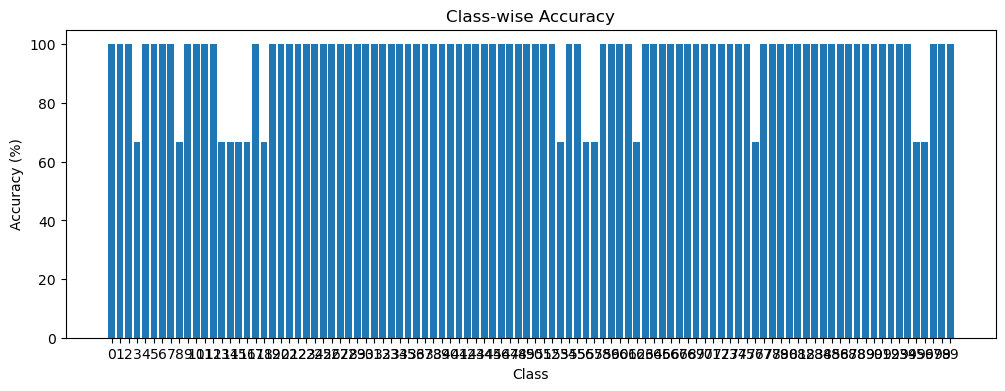

In [8]:
from model import HundredClassResNet
from data import HundredClassDataset
from torch.utils.data import DataLoader
from tqdm import tqdm

num_classes = 100
val_path = os.path.join("hw1-data", "data", 'val')

model = HundredClassResNet()
model.load_state_dict(torch.load("resnet50-mysample2/15_9020.pth"))
device = "cuda"
model.to(device)
model.eval()

label2paths = {
    i: [ os.path.join(val_path, str(i), f) for f in os.listdir(os.path.join(val_path, str(i))) ]
    for i in range(100)
}
dataset = HundredClassDataset(label2paths=label2paths, split="val")
dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)

correct_class = torch.zeros(num_classes, dtype=torch.int64).to(device)
total_class = torch.zeros(num_classes, dtype=torch.int64).to(device)

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        for i in range(labels.size(0)):
            total_class[labels[i]] += 1
            if predicted[i] == labels[i]:
                correct_class[labels[i]] += 1

accuracy = 100 * torch.sum(correct_class).item() / torch.sum(total_class).item()
print(f"Accuracy: {accuracy:.2f}%")

# 繪製每個類別的準確率圖表
class_accuracies = []
for i in range(num_classes):
    if total_class[i] > 0:
        class_accuracy = 100 * correct_class[i].item() / total_class[i].item()
        class_accuracies.append(class_accuracy)
    else:
        class_accuracies.append(0)  # 如果類別沒有樣本，則準確率為 0

plt.figure(figsize=(12, 4))
plt.bar(range(num_classes), class_accuracies)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.xticks(range(num_classes))
plt.show()

### Get the testing label

In [9]:
dataset_test = HundredClassDataset(split="test")
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False, num_workers=4)

model.eval()

data = [
    {"image_name": image_name, "pred_label": -1}
    for image_name in dataset_test.get_file_names()
]
current_idx = 0

with torch.no_grad():
    for images, labels in tqdm(dataloader_test):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        predicted = predicted.cpu().tolist()
        for label in predicted:
            data[current_idx]["pred_label"] = label
            current_idx += 1

100%|██████████| 37/37 [00:08<00:00,  4.55it/s]


In [10]:
import csv

with open('prediction.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(data[0].keys())
    for row in data:
        writer.writerow(row.values())